---
title: "Quality Control: Relatedness & Population Stratification"
format:
  html:
    code-fold: false
    toc: true
  ipynb:
    toc: true
    number-sections: false
bibliography: references/references_4.bib
---

::: {.callout-note title="Important notes for this notebook" icon=false}

As we have already mentioned, quality control (QC) analyses are crucial to ensure the reliability and validity of the results. In this section, we will explore confounding factors in GWAS that can lead to spurious associations if not properly controlled, including: 

-  Relatedness  
- Population Stratification/Structure

## Learning outcomes

- **Discuss** confounding factors that lead to spurious associations
- **Detect** related individuals
- **Identify** population substructure
- **Correct** for population stratification 

## How to make this notebook work

In this notebook, we will both use `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images.
* We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel

:::

## A. Relatedness

Relatedness refers to the presence of genetically related individuals in a study sample, which can introduce confounding factors into association analyses. Since most statistical methods assume that samples are independent, including related individuals, like siblings, violates this assumption. Addressing relatedness is crucial as a quality control step to ensure that genomes in the dataset are no more similar than expected for unrelated individuals. This process is essential to preserve the validity of the study's findings.

While all humans share some genetic relatedness, the degree of relatedness varies among individuals. In genome-wide association studies (GWAS), these variations must be accounted for to avoid biasing the statistical associations between genotypes and phenotypes. **Cryptic relatedness** (genetic relatedness of individuals not expected to be in a family relationship) can interfere with the association analysis [@voight2005confounding]. 

In a **family-based study** (e.g., parent-offspring), you do not need to remove related pairs, but the statistical analysis should account for family relatedness. However, for a **population-based study**, we suggest using the KING estimator [@KING2010] with a threshold of 0.2.

Differently from the IBD estimator (called pi_hat $\hat{\pi}$), which assumes that individuals come from homogeneous population, KING derives a kinship estimate for a pair of individuals without reference to the population allele frequencies. Instead, it gets the relatedness information from the difference between the counts of loci where both individuals are heterozygotes and counts of loci where they are different homozygotes, normalized by the sum of the heterozygous loci of the individuals. This makes KING robust to population structure and useful to check genotyping quality.

Thus, values for KING are

- 0.25 for parent-child or full siblings: they share exactly 50% of their alleles by descent (IBD). For full siblings it can vary slightly (e.g. recombination events).
- 0.125 for half siblings: they have 25% IBD (one parent is common).
- 0.065 for 1st cousins: IBD is 12.5% since they share one set of grandparents and not parents.

KING values need to be multiplied by 2 to match the corresponding IBD probability

<img src="Images/bash.png" alt="Bash" width="40"> 

We use `ln -sf` to link the data folder and create a directory for output files. 

In [1]:
ln -sf ../Data
mkdir -p Results/GWAS4

### Analysis with PLINK

We will use the set of independent SNPs (generated in the previous section) and the `--make-king-table` option in PLINK2 for our analysis, so that we generate pairwise KING estimators. Note that we use version 2 of PLINK because this one has implemented the KING estimator.

The HapMap dataset is known to contain parent-offspring relationships. We will check the KING estimator values and exclude all individuals above a chosen threshold (to remove at least related individuals).

In [16]:
plink2 --bfile Results/GWAS3/HapMap_3_r3_7 \
       --extract Results/GWAS3/indepSNP.prune.in --make-king-table \
       --out Results/GWAS4/KING

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/KING.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_7
  --extract Results/GWAS3/indepSNP.prune.in
  --make-king-table
  --out Results/GWAS4/KING

Start time: Mon Mar 17 13:04:14 2025
385567 MiB RAM detected, ~349644 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
161 samples (84 females, 77 males; 110 founders) loaded from
Results/GWAS3/HapMap_3_r3_7.fam.
1073788 variants loaded from Results/GWAS3/HapMap_3_r3_7.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--extract: 107199 variants remaining.
107199 variants remaining after main filters.
--make-king-table pass 1/1: Scanning for rare variants... done.
0 variants handled by initial scan (107199 remaining).
--make-king-table pass 1/1: Writing... done.
--make-king-table: 107199 va

The table from PLINK2 contains various things: 

- `FID1`: Family ID of the first individual.
- `IID1`: Individual ID of the first individual.
- `FID2`: Family ID of the second individual.
- `IID2`: Individual ID of the second individual.
- `NSNP`: The number of SNPs used to calculate the kinship between the two individuals.
- `HETHET`: The number of heterozygous sites used in the kinship calculation (often useful for checking genotyping quality).
- `IBS0`: The number of identical-by-state (IBS) 0 SNPs, which are variants where the two individuals do not share the same allele.
- `KINSHIP`: The kinship coefficient (or pihat) between the two individuals, which is the proportion of alleles shared by descent.

:::{.callout-important title="Stop - Read - Solve"}

- What assumption in association studies is violated when individuals are related?
- How would you recognize if the same sample is duplicated in your dataset?
- Are there closely related individuals? How many individuals show close relatedness (`KING > 0.2`)?
- What relationships are found by PLINK?

:::

In [3]:
# Write your code here (add more cells if needed)

:::{.callout-tip title="Solution" collapse=true}

- If you have related individuals, you will lose the independence of individuals at each SNP. This is a problem because many models used in GWAS analysis do not include handling family relationships.
- Calculating the KING coefficient and looking for a value close to 0.5.
- We will look for unique values in column 8 (`KINSHIP`), rounding to two decimals
- We will examine `KINSHIP` values in column 8. 

:::

 Let's print the first few rows of `KING.kin0` and then, the unique relatioship categories in the file: 

In [19]:
cat Results/GWAS4/KING.kin0 | head -5

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP
1377	NA11891	1328	NA06989	105745	0.141359	0.0697905	0.000417305
1349	NA11843	1328	NA06989	106887	0.140803	0.0701676	0.000194882
1349	NA11843	1377	NA11891	105915	0.140452	0.0696502	-6.82892e-05
1330	NA12341	1328	NA06989	106633	0.144027	0.0685248	0.00797672


Now, let's calculate how many samples are in a pair with KING `KINSHIP` parameter (column 8) larger than 0.06, 0.12, 0.2 (to account for small variations in relevant thresholds). Note that the file contains one individual of a pair, so some samples might be shown many times. Thus we make those samples unique.

In [8]:
awk '{ if ($8 > 0.06) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

77


In [9]:
awk '{ if ($8 > 0.12) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

77


In [10]:
awk '{ if ($8 > 0.2) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

77


There are 76 individuals with KINSHIP larger than all thresholds. So we might have 76 half siblings, cousins and siblings mixed in the data. There are potentially some family ties in this data!

---------------

<img src="Images/R.png" alt="R" width="40"> Switch to the R-GWAS kernel.


:::{.callout-important title="Stop - Read - Solve"}

Write some R code to calculate the summary of the distribution of `KINSHIP` values. What do you observe?

hint: use the `hist()` command.
:::

In [ ]:
# Write your code here 

:::{.callout-tip title="Solution"}
Many parent-offspring (PO) relationships have a parameter close to 0.5, and the maximum value for unrelated (UN) individuals is also unexpectedly high relatedness.

:::

We read in the matrix (Note that the header starts with # in the file `KING.kin0`, so we need `comment.char = '|'` to avoid the header being excluded as a comment) 

In [1]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/KING.kin0", header=TRUE, comment.char = '|')

head(relatedness)

,X.FID1,IID1,FID2,IID2,NSNP,HETHET,IBS0,KINSHIP
,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1377,NA11891,1328,NA06989,105745,0.141359,0.0697905,4.17305e-04
2,1349,NA11843,1328,NA06989,106887,0.140803,0.0701676,1.94882e-04
3,1349,NA11843,1377,NA11891,105915,0.140452,0.0696502,-6.82892e-05
4,1330,NA12341,1328,NA06989,106633,0.144027,0.0685248,7.97672e-03
5,1330,NA12341,1377,NA11891,105660,0.143252,0.0681810,5.60575e-03
6,1330,NA12341,1349,NA11843,106806,0.143569,0.0702957,1.79513e-03


Now we look at how many pairs have specific relatedness values. You can see there are around 100 pairs of cousins/half siblings/siblings. Those correspond to the 76 unique samples observed before.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_bar()`).”


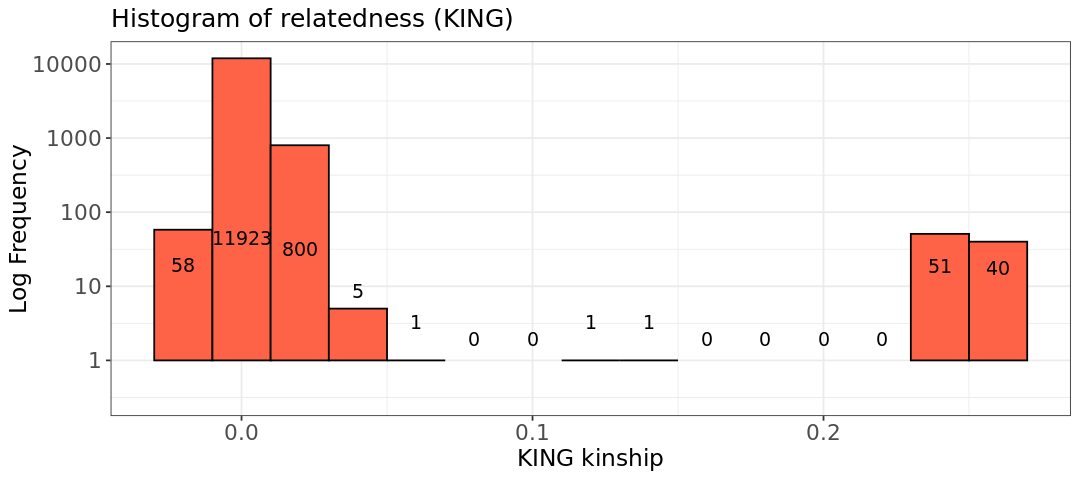

In [2]:
hist.king <- ggplot(relatedness, aes(x=relatedness[,8])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (KING)") + 
  xlab("KING kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -5, #Vertical adjustment of text
                size = 4, 
                color = "black")

We can also plot the number of SNPs used to calculate relatedness VS the KING relatedness itself. Pairs with very low number of SNPs and anomalous KING estimator might simply contain badly genotyped sample(s). This is not at all our case.

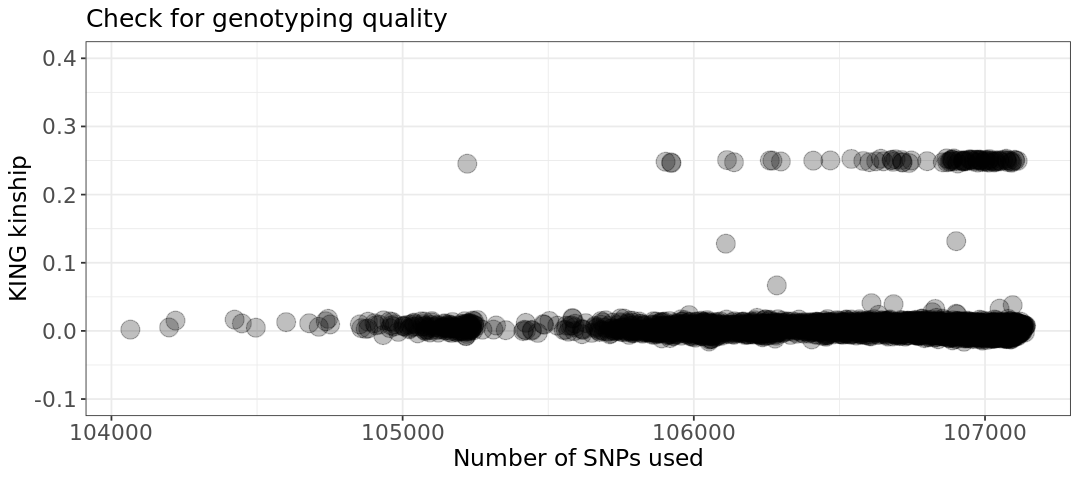

In [3]:
# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=NSNP, y=KINSHIP), size=5, alpha=.25) + 
  ylim(-.1,.4) +
  labs(x = "Number of SNPs used", y = "KING kinship", title = "Check for genotyping quality") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13), 
        legend.text= element_text(size=13), 
        legend.title=element_text(size=14), 
        plot.title=element_text(size=15))

show(plot.relatedness)

:::{.callout-important title="Stop - Read - Solve"}
Use `PLINK` options to filter out related individuals, using a relatedness threshold of 0.1. 

- First of all you need to create a file with the IDs of the samples to remove. You can use the command `awk` as we did before in this exercise.

- Afterwards you need PLINK with the option `--remove` to use the file with IDs. Name the output `--out Results/GWAS4/king_exercise`.

:::

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

In [5]:
# Write your code here (PLINK command)


:::{.callout-tip title="Solution"}

We use `awk` to print IDs to remove and then the option `--remove` of PLINK. 

:::

<img src="Images/bash.png" alt="Bash" width="40"> We print out all family and sample IDs for which the column KINSHIP (column 8) is >0.1. Note we print both samples in the pair with high relatedness, using the `awk` command twice.

In [1]:
awk '{ if ($8 > 0.1) print $1, $2 }' Results/GWAS4/KING.kin0 > Results/GWAS4/filter_king.txt

Now each sample is identified uniquely ba family and sample ID. Some samples are repeated more than once because we have selected the first sample in related pairs, so same samples appear more than once. We use the option `--remove` to produce a new set of `plink` files. We will be warned about sample repetitions because we have been having some duplicates from the KINSHIP pairs

In [2]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 --make-bed --remove Results/GWAS4/filter_king.txt --out Results/GWAS4/king_exercise

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/king_exercise.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_7
  --make-bed
  --out Results/GWAS4/king_exercise
  --remove Results/GWAS4/filter_king.txt

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073788 variants loaded from .bim file.
161 people (77 males, 84 females) loaded from .fam.
110 phenotype values loaded from .fam.
--remove: 85 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 67 founders and 18 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate in remaining samples is 0.997765.
1073788 variants and 85 people pass filters and QC.
Among remaining phenotypes, 34 are cases and 33 are controls.  (18 phenotypes
are missing.)
--make-bed to Results/GWAS4/king_exercise.bed + Results/GWA

We have gone from 161 to 85 samples, removing 76 related ones.

***

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

So far, you’ve learned how to filter individuals using KING kinship thresholds. Now, we’ll demonstrate that most of the relatedness was due to parent-offspring relationships. We will achieve this by using the `--filter-founders` option to create a new filtered dataset that includes only the founders (individuals without listed parents in the data). This generates `.bed`, `.bim`, and `.fam` files, which are then used to create a `.kin0` file containing relatedness values. Note again we use `plink2` to create the KING matrix.

In [11]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 --filter-founders --make-bed --out Results/GWAS4/HapMap_3_r3_8 --silent

plink2 --bfile Results/GWAS4/HapMap_3_r3_8 --extract Results/GWAS3/indepSNP.prune.in --make-king-table --out Results/GWAS4/KING_founders

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/KING_founders.log.
Options in effect:
  --bfile Results/GWAS4/HapMap_3_r3_8
  --extract Results/GWAS3/indepSNP.prune.in
  --make-king-table
  --out Results/GWAS4/KING_founders

Start time: Tue Mar 18 12:52:28 2025
385567 MiB RAM detected, ~340647 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
110 samples (55 females, 55 males; 110 founders) loaded from
Results/GWAS4/HapMap_3_r3_8.fam.
1073788 variants loaded from Results/GWAS4/HapMap_3_r3_8.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--extract: 107199 variants remaining.
107199 variants remaining after main filters.
--make-king-table pass 1/1: Scanning for rare variants... done.
0 variants handled by initial scan (107199 remaining).
--make-king-table pass 1/1: Writing... done.
--make-kin

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let's plot the results from the `KING_founders.kin0` file. We can see how there is only 1 pair with high kinship amongst the founders.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_bar()`).”


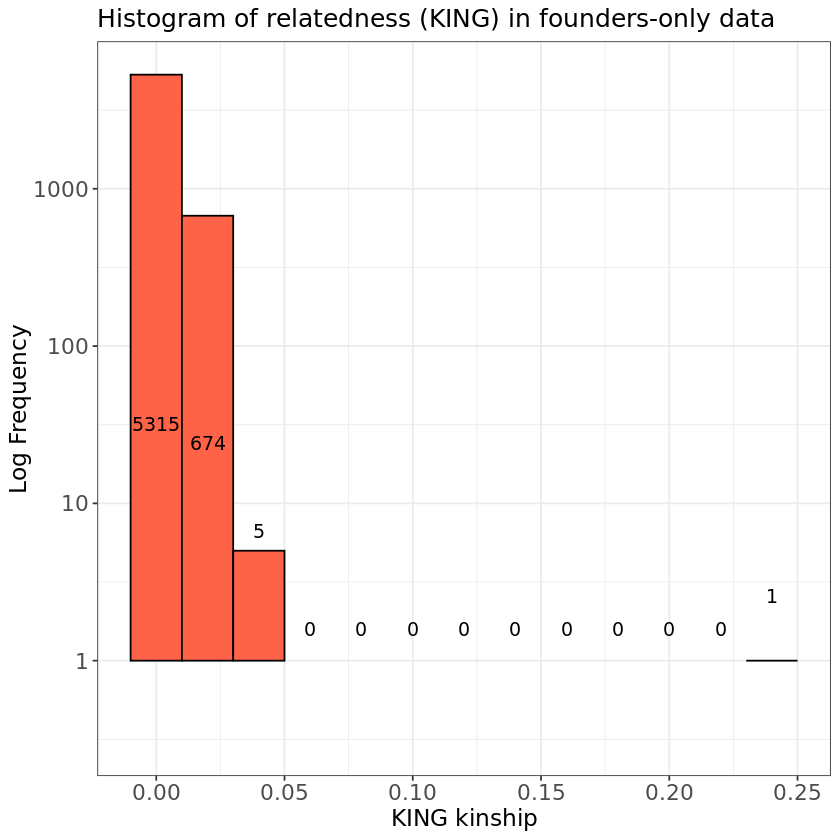

In [1]:
suppressMessages(suppressWarnings(library(ggplot2)))

relatedness <- read.table("Results/GWAS4/KING_founders.kin0", header=TRUE, comment.char = '|')

hist.king <- ggplot(relatedness, aes(x=relatedness[,8])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (KING) in founders-only data") + 
  xlab("KING kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -10, #Vertical adjustment of text
                size = 4, 
                color = "black")

:::{.callout-important title="Stop - Read - Solve"}

- **1. Do you observe anything unexpected in the plot?**
- **2. Can you identify the IIDs of the sample pair?** Hint: filter for KINSHIP values.
- **3. Based on the KINSHIP, what is the most likely relationship between the pair?**
- **4. What would you do about it?** Hint: remove one or both in the pair?

:::

In [ ]:
# Write your answer here

In [ ]:
# R code here

:::{.callout-tip title="Solution" collapse=true}

- **1.** The file `KING_founders.kin0` shows that, after excluding all non-founders, one individual pair removed in the exercise remains in the HapMap data. 
- **2.** Below, we can look at the individual from the table by setting KINSHIP > 0.2. Even if labeled as unrelated, it has high relatedness. The IIDs of the pair are NA07045 and NA12813. 

:::

In [6]:
relatedness[relatedness$KINSHIP > 0.2,]

,X.FID1,IID1,FID2,IID2,NSNP,HETHET,IBS0,KINSHIP
,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
2729,1454,NA12813,13291,NA07045,106716,0.210015,0.0181322,0.247089


- **3.** This remaining individual is likely to be related with sibling relationship, even though they were not given the same family identity (FID) in the HapMap data.
- **4.** We don't need to remove both individuals from the dataset (IID1=NA07045; IID2=NA12813). It's enough to remove just one, and the individual with the highest missing rate (lowest quality) could be chosen. Let's calculate the missing rates using PLINK.

***

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

In [8]:
plink --bfile Results/GWAS4/HapMap_3_r3_8 --missing --out Results/GWAS4/HapMap_3_r3_8 --silent

Then, find the two individuals from the output file using `grep` and sorting descendingly by missing rate (EZ, column 6)

In [3]:
# Let's look at the output
cat Results/GWAS4/HapMap_3_r3_8.imiss | grep -E 'NA07045|NA12813' | sort -k6,6nr

  13291   NA07045          N     2560  1073788 0.002384
   1454   NA12813          N     1956  1073788 0.001822


`NA07045` is the individual to be removed. Once this is removed, their offspring can still be used in analyses that don't involve trios, such as family-related studies.

:::{.callout-important title="Stop - Read - Solve"}

- **Plot the distribution of missing rates from `HapMap_3_r3_8`. What is the value for `NA07045`?**
- **Remove `NA07045` from the PLINK files**
  
Hint: 

- Use the `.imiss` file to plot a histogram of the missing scores from the file `HapMap_3_r3_8.imiss` in `R` (check previous notebooks for help). Is the score of `NA07045` amongst the higher/lower ones? You can add a vertical line in the histogram representing the value for `NA07045` using `geom_vline`. 
- Create a file with the sample ID to remove and use the `--remove` option in PLINK. 

:::

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

In [1]:
# Write your code here

:::{.callout-tip title="Solution"}
We can extract the column from the file and observe in the histogram that the individual `NA07045` has a missing rate closer which is in the bulk of other samples.

:::

,X.FID,IID,PHENO1,MISSING_CT,OBS_CT,F_MISS
,<int>,<chr>,<chr>,<int>,<int>,<dbl>
1,1328,NA06989,N,2202,1073788,0.002050680
2,1377,NA11891,N,13607,1073788,0.012672000
3,1349,NA11843,N,821,1073788,0.000764583
4,1330,NA12341,N,3708,1073788,0.003453200
5,1328,NA06984,N,6484,1073788,0.006038440
6,1418,NA12275,N,2740,1073788,0.002551710


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


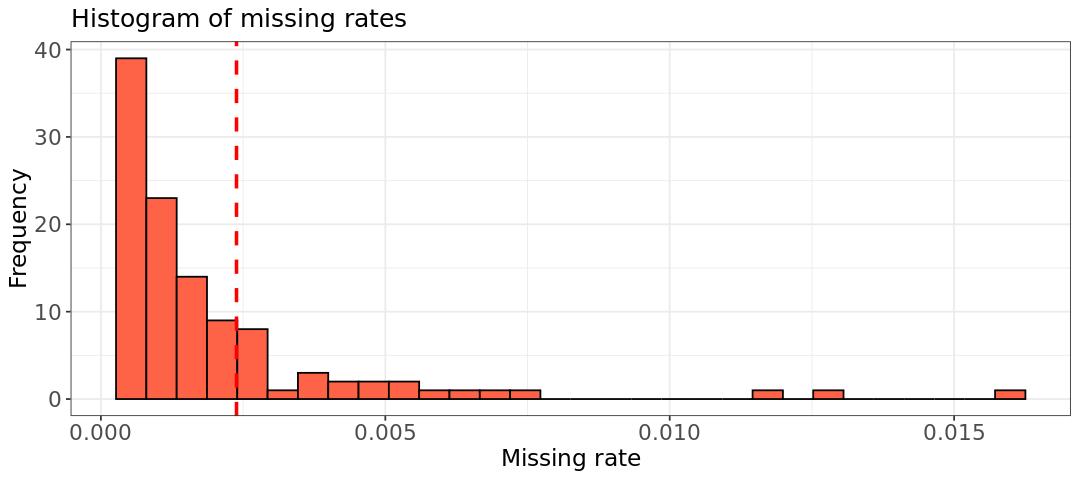

In [2]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
smiss <- read.table("Results/GWAS4/HapMap_3_r3_8.smiss", header=T, comment.char = '|')

head(smiss)

hist.relatedness <- ggplot(data=smiss, aes(F_MISS)) +
  geom_histogram(col = "black", fill = "tomato") + 
  geom_vline(xintercept = 0.002384, color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Histogram of missing rates") + 
  xlab("Missing rate") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=13),plot.title=element_text(size=15))

show(hist.relatedness)


<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

To remove the individual from the data, we create a file containing its number and ID, and provide it to PLINK with the option `--remove`

In [1]:
echo "13291  NA07045" > Results/GWAS4/id_remove.txt

In [12]:
# Delete the individuals with the lowest call rate in 'related' pairs with a pihat > 0.2 
plink --bfile Results/GWAS4/HapMap_3_r3_8 --remove Results/GWAS4/id_remove.txt --make-bed --out Results/GWAS4/HapMap_3_r3_9 --silent

***

## B. Population Stratification

Population stratification presents a significant source of systematic bias in GWAS, arising **when subpopulations exhibit systematic differences in allele frequencies**. Research indicates that even subtle degrees of population stratification can exist within a single ethnic population [@abdellaoui2013population]. Thus, testing and controlling for the presence of population stratification is an essential QC step.

The population structure (or in other words, the ancestral relationship of the populations) is a so-called **confounding factor**. This means that it affects both the dependent and independent variables, as shown in the figure below, where both the genotype and traits are influenced by population structure (e.g., the distribution of north and south European individuals in the PCA space and the height of those individuals).

![](Images/ancestryBias.png){fig-align="center" width=70%}

Why is a bias introduced? Population structure can influence allele frequencies and produce false positives/negatives when doing association testing. Graphically, consider the example in the figure below. Case and control for population 1 and 2 have specific MAFs. Removing the barrier between populations will change MAFs drastically for the two confitions.

![](Images/popStruct.png){fig-align="center" width=70%}

The same problem arises in population studies without Case-control categories. Imagine having a population of randomly sampled individuals, each from a different ethnicity (the blue and red minor alleles in the example below). The final group of individuals will have a different proportion of MAFs depending on the sampling of various ethnicities.

![](Images/popSampling.png){fig-align="center" width=70%}

There are several methods to correct for population stratification [@price2010new, price_principal_2006]. Here, we illustrate a method integrated into PLINK: the **multidimensional scaling (MDS)** approach. MDS calculates the genome-wide average proportion of shared alleles between any pair of individuals to generate quantitative indices (components) of the genetic variation for each individual. **The individual component scores can be visualized to identify groups of genetically similar individuals.** For instance, in a genetic study including subjects from Asia and Europe, MDS analysis would reveal that Asians are genetically more similar to each other than to Europeans and Africans. The figure below shows another example of MDS using HapMap, Genome diversity project, and authors' data:

![Example of MDS plot of the first two MDS components scores on integrated datasets in @somers_genetic_2017. Here TWN, a past isolated population in the Netherlands, is separated from the other individuals from the same country (NDL). Sardinians, notoriously different from continental Italians, are also grouped far away from them. Central European populations colocalize as expected.](./Images/MDSexample2.png){width=500px label=fig-MDSexample}

To investigate which individuals the generated component scores deviate from in the target population, plotting the scores of the dataset under investigation and a population of known ethnic structure (e.g., HapMap/1KG data) is helpful: this step is called **anchoring** [@rietveld2013gwas]. This enables the researcher to obtain ethnic information on their data and to determine possible ethnic outliers. For example, in the figure above, if TSI (Tuscans from Italy) is the anchor population, one can hypothesize that the yellow dots might be ethnically similar (as in the example).

Outliers identified based on MDS analysis should be excluded from further analyses. Following their removal, a new MDS analysis must be conducted, and its primary components are utilized as covariates in association tests to correct for any residual population stratification within the population. The number of components to include depends on the population structure and sample size (usually 10-20). 

The MDS from @cortellari_climatic_2021 shows a distinct goat population outlier. The second axis is dominated by this outlier, obscuring structure in the other populations. Removing the outlier reveals a clearer structure among the remaining populations.

![](./Images/MDSout.png)


:::{.callout-important title="Stop - Read - Solve"}

It is also possible to correct for relatedness (family structure). **Should we also do it?**

:::

### Analysis 

We aim to merge the HapMap and 1000GP datasets, using 1000GP Phase I as the anchor for HapMap. Our goal is to check if we can identify the ethnicity of the HapMap data based on the ethnicities in the 1000GP dataset. There are several steps to ensure compatibility between the datasets, so stay with us!

#### 1000GP data download

Here are some commands to download and convert the 1000GP data for GWAS analysis. **You don’t need to run them**, as we’ve already processed the data.

- 1000 Genomes Project - Phase I: genetic information for 629 individuals from various ethnic groups (>60GB). *Phase III is now available, and we recommend using it for research purposes.*


```{.bash}
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz
```

The data was converted from the `vcf` file (Variant Call Format) to plink format (`bim`, `fam`, `bed`):

```{.bash}
plink2 --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz --make-bed --out ALL.2of4intersection.20100804.genotypes
```

:::{.callout-note}

The 1000 Genomes data downloaded above is rather large so the commands are not executable and are shown for reference only. To save time, we’ve provided the `.bed`, `.bim`and `.fam` files in the `Data` folder.

:::

Let's unzip the files and see how many samples we have.

In [3]:
unzip -o Data/1000genomes.zip -d Results/GWAS4
# count lines in fam 
wc -l Results/GWAS4/1000genomes.genotypesA.fam

Archive:  Data/1000genomes.zip
  inflating: Results/GWAS4/1000genomes.genotypesA.bed  
  inflating: Results/GWAS4/1000genomes.genotypesA.bim  
  inflating: Results/GWAS4/1000genomes.genotypesA.fam  
  inflating: Results/GWAS4/1000genomes.genotypesA.log  
  inflating: Results/GWAS4/1000genomes.genotypesA.nosex  
37 Results/GWAS4/1000genomes.genotypesA.fam


We have a subset of **37 individuals**. Now, let's explore the `bim` file. 

In [4]:
cat Results/GWAS4/1000genomes.genotypesA.bim | head -5

1	rs112750067	0	10327	C	T
1	.	0	11508	A	G
1	.	0	12783	G	A
1	.	0	13116	G	T
1	.	0	14933	A	G


One should note that the file `1000genomes.genotypes.bim` contains SNPs without an rs-identifier (or Reference SNP cluster ID). The missing rs-identifiers (noted as `.`) are not a problem for this tutorial. However, for good practice, we will assign unique identifiers to the SNPs (using available information):

In [7]:
plink --bfile Results/GWAS4/1000genomes.genotypesA --set-missing-var-ids @:#[b37]\$1,\$2 --make-bed --out Results/GWAS4/1000genomes.genotypesA_no_missing_IDs --silent

Now, let’s visualize the data to check the SNP names assigned. These are derived from the format `@:#[b37]\$1,\$2` in the command above, which PLINK interprets as `chromosome:locus[b37]Allele1,Allele2`: 

In [6]:
# Show changes on the bim file
cat Results/GWAS4/1000genomes.genotypesA_no_missing_IDs.bim | head -5

1	rs112750067	0	10327	C	T
1	1:11508[b37]A,G	0	11508	A	G
1	1:12783[b37]A,G	0	12783	G	A
1	1:13116[b37]G,T	0	13116	G	T
1	1:14933[b37]A,G	0	14933	A	G


Pretty neat, right?

#### QC on 1000GP data
As we covered in the GWAS3 notebook, it's important to account for missingness, sex discrepancies, and minor allele frequency. We'll apply standard QC thresholds to the 1000 GP data before merging it with HapMap data. 

In [6]:
plink --bfile Results/GWAS4/1000genomes.genotypesA_no_missing_IDs --geno 0.02  \
    --allow-no-sex --make-bed --out Results/GWAS4/1kG_MDS --silent

plink --bfile Results/GWAS4/1kG_MDS --mind 0.02  \
    --allow-no-sex --make-bed --out Results/GWAS4/1kG_MDS2 --silent
    
plink --bfile Results/GWAS4/1kG_MDS2 --maf 0.05 \
      --allow-no-sex --make-bed  --out Results/GWAS4/1kG_MDS3 --silent

#### SNPs matching between datasets

N.B: Ensure that the datasets you want to merge share the same genomic build! Otherwise, you'll need to include a liftover step.


We want to only consider SNPs that both datasets have in common.  First, extract SNP names from the HapMap data and filter the 1000GP data to include only matching SNPs.


In [8]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/HapMap_3_r3_9.bim > Results/GWAS4/HapMap_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/1kG_MDS3 --extract Results/GWAS4/HapMap_SNPs.txt \
--make-bed --out Results/GWAS4/1kG_MDS4

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/1kG_MDS4.log.
Options in effect:
  --bfile Results/GWAS4/1kG_MDS3
  --extract Results/GWAS4/HapMap_SNPs.txt
  --make-bed
  --out Results/GWAS4/1kG_MDS4

385567 MB RAM detected; reserving 192783 MB for main workspace.
2232052 variants loaded from .bim file.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to Results/GWAS4/1kG_MDS4.nosex .
--extract: 376560 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 37 founders and 0 nonfounders present.
Calculating allele frequencies... done.
376560 variants and 37 people pass filters and QC.
Note: No phenotypes present.
--make-bed to Results/GWAS4/1kG_MDS4.bed + Results/GWAS4/1kG_MDS4.bim +
Results/GWAS4/1kG_MDS4.fam ... done.


This is how part of the list of SNP names looks like:

In [9]:
cat Results/GWAS4/HapMap_SNPs.txt | head -5

rs3131972
rs3131969
rs1048488
rs12562034
rs12124819


Now we take the variants from the reduced 1000GP data, and go the other way around. We extract 1000GP variants from the HapMap data. In other words, the two extraction passages will intersect the SNPs. Below is the code to use the SNPs of the 1000GP data to reduce the HapMap data.

In [10]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/1kG_MDS4.bim > Results/GWAS4/1kG_MDS4_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/HapMap_3_r3_9 --extract Results/GWAS4/1kG_MDS4_SNPs.txt --make-bed --out Results/GWAS4/HapMap_MDS

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/HapMap_MDS.log.
Options in effect:
  --bfile Results/GWAS4/HapMap_3_r3_9
  --extract Results/GWAS4/1kG_MDS4_SNPs.txt
  --make-bed
  --out Results/GWAS4/HapMap_MDS

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073788 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
--extract: 376560 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998017.
376560 variants and 109 people pass filters and QC.
Among remaining phenotypes, 54 are cases and 55 are controls.
--make-bed to Results/GWAS4/HapMap_MDS.bed + Results/GWAS4/HapMap_MDS.bim +
Results/GWAS4/HapMap_MDS.fam .

Look at the SNP names. Now, they are matching between the two `bim` files.

:::{.callout-important title="Stop - Read - Solve"}

**Look at the two outputs a bit more carefully. Is there any problem?**

Hint: 

- compare the chromosome and position across the 2 datasets.
- compare the two alleles 

:::

In [11]:
head Results/GWAS4/HapMap_MDS.bim

1	rs3131969	0	744045	A	G
1	rs12562034	0	758311	A	G
1	rs4970383	0	828418	A	C
1	rs4475691	0	836671	T	C
1	rs1806509	0	843817	C	A
1	rs28576697	0	860508	C	T
1	rs3748595	0	877423	A	C
1	rs13303118	0	908247	G	T
1	rs1891910	0	922320	A	G
1	rs3128097	0	970323	G	A


In [12]:
head Results/GWAS4/1kG_MDS4.bim

1	rs3131969	0	754182	A	G
1	rs12562034	0	768448	A	G
1	rs4970383	0	838555	A	C
1	rs4475691	0	846808	T	C
1	rs1806509	0	853954	A	C
1	rs28576697	0	870645	C	T
1	rs3748595	0	887560	A	C
1	rs13303118	0	918384	T	G
1	rs1891910	0	932457	A	G
1	rs3128097	0	980460	G	A


#### Build matching

Genomic data is based on a reference genome, and our datasets use different human reference versions. Since the reference genome improves over time, SNP positions may differ between datasets from different versions.

We extract SNP names and positions from the HapMap data and align the 1000GP data to match these SNPs using the `--update-map` option in PLINK.

In [13]:
#Extract the HapMap variant coordinates
awk '{print$2,$4}' Results/GWAS4/HapMap_MDS.map > Results/GWAS4/buildhapmap.txt

This is how the list of SNPs look like:

In [14]:
cat Results/GWAS4/buildhapmap.txt | head -5

rs3131969 744045
rs12562034 758311
rs4970383 828418
rs4475691 836671
rs1806509 843817


We run PLINK to update the 1000GP variant coordinates based on HapMap, ignoring the warning about unsorted positions: 

In [32]:
plink --bfile Results/GWAS4/1kG_MDS4 --update-map Results/GWAS4/buildhapmap.txt --make-bed \
--out Results/GWAS4/1kG_MDS5

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/1kG_MDS5.log.
Options in effect:
  --bfile Results/GWAS4/1kG_MDS4
  --make-bed
  --out Results/GWAS4/1kG_MDS5
  --update-map Results/GWAS4/buildhapmap.txt

385567 MB RAM detected; reserving 192783 MB for main workspace.
376560 variants loaded from .bim file.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to Results/GWAS4/1kG_MDS5.nosex .
--update-map: 376560 values updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 37 founders and 0 nonfounders present.
Calculating allele frequencies... done.
376560 variants and 37 people pass filters and QC.
Note: No phenotypes present.
--make-bed to Results/GWAS4/1kG_MDS5.bed + Results/GWAS4/1kG_MDS5.bim +
Results/GWAS4/1kG_MDS5.fam ... done.


#### Merging datasets and performing MDS

Before merging the HapMap and 1000 Genomes datasets, we ensure compatibility through 3 steps:

1. Verify the reference genome is compatible in both datasets.
2. Align SNP orientations (strand) across datasets.
3. Remove SNPs that still differ after these steps.

The next steps are technical but ensure the datasets correspond correctly.


**1.** We’ve matched SNP positions, but we also need to ensure the reference alleles align. Remember that most PLINK analyses **consider the A1 allele (typically the minor allele) as the reference allele**, which is logical when dealing exclusively with biallelic variants.

Below, we generate a list of SNPs ID and 'reference alleles' (corresponding to A1, column 5) from 1000GP.

In [33]:
#Extract variant coordinates and reference alleles from 1000GP data
awk '{print$2,$5}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kg_ref-list.txt

How the list looks like:

In [34]:
head -5 Results/GWAS4/1kg_ref-list.txt

rs3131969 A
rs12562034 A
rs4970383 A
rs4475691 T
rs1806509 A


Then, we assign them to the HapMap data `--ref-allele` option. Note a lot fo warnings in A1 allele assignment. This is usually because you have a strand issue, where the data uses a complement

In [35]:
plink --bfile Results/GWAS4/HapMap_MDS  --make-bed \
    --reference-allele Results/GWAS4/1kg_ref-list.txt  \
    --out Results/GWAS4/HapMap-adj 

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/HapMap-adj.log.
Options in effect:
  --a1-allele Results/GWAS4/1kg_ref-list.txt
  --bfile Results/GWAS4/HapMap_MDS
  --make-bed
  --out Results/GWAS4/HapMap-adj

385567 MB RAM detected; reserving 192783 MB for main workspace.
376560 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998017.
--a1-allele: 376560 assignments made.
376560 variants and 109 people pass filters and QC.
Among remaining phenotypes, 54 are cases and 55 are controls.
--make-bed to Results/GWAS4/HapMap-adj.bed + Results/GWAS4/HapMap-adj.bim +
Results/GWAS4/HapMap-adj.fam ... 

**2.** To resolve strand issues, we flip SNPs found in both datasets with complementary alleles (i.e. they were reported in opposite strands). We generate SNP lists (ID and alleles) for both datasets, identify unique SNPs, and visualize differences in allele reporting. If a SNP is unique but reports alleles differently, it will appear twice. Below are examples of SNPs with strand issues from the 1000GP and HapMap data:

In [39]:
#print SNP and A1 A2 alleles on files for the two datasets
awk '{print$2,$5,$6}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kGMDS5_tmp
awk '{print$2,$5,$6}' Results/GWAS4/HapMap-adj.bim > Results/GWAS4/HapMap-adj_tmp

#sort by SNP name to see SNPs with complementary alleles
sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/HapMap-adj_tmp |uniq -u > Results/GWAS4/all_differences.txt

In [40]:
head -6 Results/GWAS4/all_differences.txt

rs10006274 C T
rs10006274 G A
rs1008660 A G
rs1008660 T C
rs10088098 C T
rs10088098 G A


**How many of these differences are there?** We can count 604 lines, so 302 SNPs

In [68]:
wc -l Results/GWAS4/all_differences.txt

604 Results/GWAS4/all_differences.txt


Some of these differences might be might be due to strand issues.

Let's look at this variant `rs10006274`. **Will it be flipped in the HapMap dataset?**

The answer is yes! If we look at the reference allele in `1kg_ref-list.txt`, it shows `C`. This means the SNP is on the forward strand in 1000GP (C/T) and on the reverse strand in HapMap (G/A).

In [41]:
grep rs10006274 Results/GWAS4/1kg_ref-list.txt

rs10006274 C


In [42]:
grep rs10006274 Results/GWAS4/all_differences.txt

rs10006274 C T
rs10006274 G A


:::{.callout-important title="Stop - Read - Solve"}

Look at these other SNPs `rs9614750` and `rs10088098`. 

- **Which ones will have to be flipped?**
- **Is it always the same dataset that must be flipped?**

:::

In [22]:
# Write your code here 

:::{.callout-tip title="Solution" collapse=true}
We will first print out the SNPs from the reference file to know which line corresponds to each dataset (since we know we used the 1000 Genomes Project as the reference). If there are strand issues, the SNP will need to be flipped in the dataset that wasn't used as the reference.

:::

In [43]:
grep rs9614750 Results/GWAS4/1kg_ref-list.txt 

rs9614750 A


In [44]:
grep rs9614750 Results/GWAS4/all_differences.txt

rs9614750 A G
rs9614750 C G


For `rs9614750`, the genotype is reported as `A/G` in the 1000GP data, while in HapMap, it is `C/G`. This discrepancy between the two datasets means that the SNP will need to be removed later.


In [45]:
grep rs10088098 Results/GWAS4/1kg_ref-list.txt 

rs10088098 C


In [46]:
grep rs10088098 Results/GWAS4/all_differences.txt

rs10088098 C T
rs10088098 G A


For `rs10088098`, the genotype is reported as `C/T` in the 1000GP data, while in HapMap, it is `G/A`. This means that PLINK will flip the allele, as they are complementary.

---

Now we take only the SNP names and give them to PLINK (option `--flip`), together with the reference genome (option `--reference-allele`):

In [47]:
## Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' Results/GWAS4/all_differences.txt | sort -u > Results/GWAS4/flip_list.txt

In [48]:
wc -l Results/GWAS4/flip_list.txt

302 Results/GWAS4/flip_list.txt


These are the SNP ID of non-corresponding SNPs (N=302) between the two files. 

In [49]:
head -5 Results/GWAS4/flip_list.txt

rs10006274
rs1008660
rs10088098
rs1011297
rs1023098


Apply the flipping option: 

In [50]:
plink --bfile Results/GWAS4/HapMap-adj --flip Results/GWAS4/flip_list.txt \
      --reference-allele Results/GWAS4/1kg_ref-list.txt \
      --make-bed --out Results/GWAS4/corrected_hapmap --silent

:::{.callout-important title="Stop - Read - Solve"}
There might still be problematic SNPs after flipping. 

- **Check if the expected allele flip occurred.**

Hint: use `grep` to find the `rs10006274` and `rs9614750` variants; then compare the alleles assignments in the HapMap file before and after flipping.

:::

In [2]:
# Write your code here 

:::{.callout-tip title="Solution" collapse=true}
PLINK attempts to flip all SNPs in the list, but an error occurs when A1 does not match the one in the reference.

:::

Notice how this SNP has changed as we predicted: 

In [51]:
grep rs10006274 Results/GWAS4/corrected_hapmap.bim

4	rs10006274	0	124165369	C	T


In [52]:
grep rs10006274 Results/GWAS4/HapMap-adj.bim

4	rs10006274	0	124165369	G	A


`rs10006274` was flipped and has the same strand orientation in both datasets (same alleles in A1 and A2). 

What happened to this one? PLINK attempts to resolve the mismatch by flipping the alleles but throws an error because the complementary alleles do not match the reference!

In [53]:
grep rs9614750 Results/GWAS4/corrected_hapmap.bim

22	rs9614750	0	44436371	G	C


In [54]:
grep rs9614750 Results/GWAS4/HapMap-adj.bim

22	rs9614750	0	44436371	C	G


:::{.callout-note}
You don't need to flip the 1000GP data because the reference allele (A1) in the 1000GP data already matches the strand orientation used in the HapMap data.

:::

**3.** After flipping SNPs, some differ in their alleles when comparing datasets to each other (e.g. SNP `rs9614750`) and such SNPs must be removed. 

We extract the SNPs from the corrected HapMap data and search for unique SNP (ID, A1, and A2), comparing them with those from the 1000GP data.

In [55]:
awk '{print$2,$5,$6}' Results/GWAS4/corrected_hapmap.bim > Results/GWAS4/corrected_hapmap_tmp

sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/corrected_hapmap_tmp | uniq -u  > Results/GWAS4/uncorresponding_SNPs.txt

**How many SNP missmatches are there?**

In [56]:
wc -l Results/GWAS4/uncorresponding_SNPs.txt

24 Results/GWAS4/uncorresponding_SNPs.txt


This corresponds to 12 unique SNP IDs with mismatched information.

In [57]:
head Results/GWAS4/uncorresponding_SNPs.txt 

rs11524965 T C
rs11524965 T G
rs12646999 G A
rs12646999 G T
rs17114359 C A
rs17114359 C T
rs17269854 C A
rs17269854 C T
rs2060424 G A
rs2060424 G C


We extract again the SNP IDs from the file above, and exclude them using the PLINK option `--exclude` in both datasets

In [13]:
awk '{print$1}' Results/GWAS4/uncorresponding_SNPs.txt | sort -u > Results/GWAS4/SNPs_for_exclusion.txt

plink --bfile Results/GWAS4/corrected_hapmap --exclude Results/GWAS4/SNPs_for_exclusion.txt \
--make-bed --out Results/GWAS4/HapMap_MDS3 --silent
plink --bfile Results/GWAS4/1kG_MDS5 --exclude Results/GWAS4/SNPs_for_exclusion.txt \
--make-bed --out Results/GWAS4/1kG_MDS6 --silent

**5.** We can finally merge the data! We provide our dataset (`-bfile`) and the one to add (`--bmerge` option):

In [59]:
plink --bfile Results/GWAS4/corrected_hapmap --bmerge Results/GWAS4/1kG_MDS6.bed Results/GWAS4/1kG_MDS6.bim Results/GWAS4/1kG_MDS6.fam \
--allow-no-sex --make-bed --out Results/GWAS4/MDS_merge --silent

### Perform MDS on HapMap-CEU data anchored by 1000 Genomes data.

MDS is typically performed on independent SNPs (pruned SNPs). We have previously identified such SNPs in this course, so we will extract only these SNPs for the analysis.

In [60]:
plink --bfile Results/GWAS4/MDS_merge --extract Results/GWAS3/indepSNP.prune.in \
    --genome --out Results/GWAS4/MDS_merge --silent

Now, we can use PLINK to run MDS with the option `---mds-plot` specifying the number of components to calculate.

In [61]:
# mds-plot
plink --bfile Results/GWAS4/MDS_merge --read-genome Results/GWAS4/MDS_merge.genome \
    --cluster --mds-plot 10 --out Results/GWAS4/MDS_merge --silent

For visualization purposes, we downloaded the 1000 Genomes Project (1000GP) panel, which includes individual names and their corresponding population information.

In [62]:
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel -P Results/GWAS4 -q

To determine the population origins of HapMap individuals, we created a new file that combines the 1000GP panel information with the HapMap data, labeling the population HapMap entries as 'OWN'.

In [63]:
awk '{print$1,$2,"OWN"}' Results/GWAS4/HapMap_MDS.fam > Results/GWAS4/popfile_own.txt
awk '{print$1,$1,$2}' Results/GWAS4/20100804.ALL.panel > Results/GWAS4/20100804.ALL.panel.txt

cat <(echo "FID IID POP") Results/GWAS4/20100804.ALL.panel.txt Results/GWAS4/popfile_own.txt > Results/GWAS4/popfile.txt

:::{.callout-note}

The 1000 Genomes Project (1000GP) categorizes individuals into major continental groups—such as Europeans (EUR), Africans (AFR), Americans (AMR), East Asians (EAS), and South Asians (SAS)—each comprising various subpopulations. We will use this population structure information to visualize and determine the clusters our samples belong to.

![](./Images/1000GP.png){width=800px}

:::

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let's visualize population stratification using the multidimensional scaling (MDS) results. 


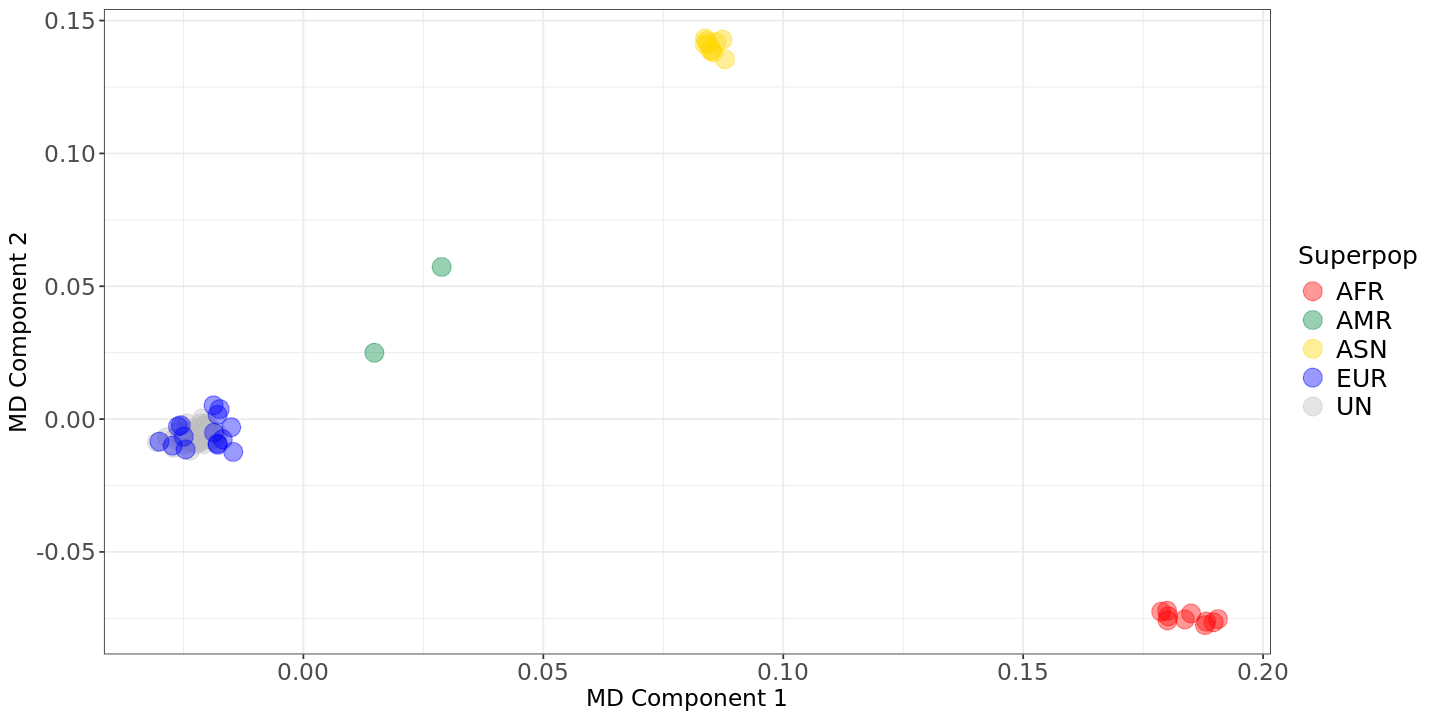

In [1]:
options(repr.plot.width = 12, repr.plot.height = 6)

suppressMessages(suppressWarnings(library(ggplot2)))

# Read data into R 
data <- read.table(file="Results/GWAS4/MDS_merge.mds",header=TRUE)
pop <- read.table(file="Results/GWAS4/popfile.txt",header=TRUE)
datafile <- merge(data,pop,by=c("FID","IID"))

# Metapopulation information for the population in the 1000GP dataset
superpop <- c(
  "JPT" = "ASN",
  "ASW" = "AFR",
  "CEU" = "EUR",
  "CHB" = "ASN",
  "CHD" = "ASN",
  "YRI" = "AFR",
  "LWK" = "AFR",
  "TSI" = "EUR",
  "MXL" = "AMR",
  "GBR" = "EUR",
  "FIN" = "EUR",
  "CHS" = "ASN",
  "PUR" = "AMR",
  "OWN" = "UN"
)

# add metapopulation info to the table 
datafile$SUPERPOP <- superpop[datafile$POP]

# Plotting                
scatter.mds <- ggplot(datafile, aes(x=C1, y=C2, color=SUPERPOP)) +
  geom_point(size=5, alpha=.4) +
  scale_color_manual(values=c("AFR" = "red", "AMR" = "springgreen4", "ASN" = "gold", "EUR" = "blue", "UN" = "grey" )) +
  xlab("MD Component 1") + 
  ylab("MD Component 2") +
  labs(color="Superpop") +
  theme_bw() +
  theme(axis.title = element_text(size = 14), legend.text = element_text(size = 15), 
        axis.text = element_text(size = 14), legend.title=element_text(size=15))
  
show(scatter.mds)

The HapMap data clusters closely with European populations such as CEU, TSI, IBS, GBR, and FIN, confirming its European composition. Additionally, the absence of distant points indicates no outliers in the HapMap dataset (grey datapoints cluster together).


#### Exclude ethnic outliers

Let's run the scripts to filter population stratification outliers for educational purposes (e.g. imagine a HapMap individual clusters in the lower-right corner with African populations). 

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

To identify and exclude ethnic outliers in the HapMap dataset, select individuals falling within specific cut-off thresholds. These thresholds should be determined based on the visualization of the first two dimensions from the multidimensional scaling (MDS) analysis. 

**What values would you select or apply in this context, and why?** Hint: look at the plot above. 

Preview of the MDS results: 

In [1]:
head -3 Results/GWAS4/MDS_merge.mds | cut -f1-6 -d$'\t'

    FID       IID    SOL           C1           C2           C3           C4           C5           C6           C7           C8           C9          C10 
   1328   NA06984      0   -0.0224314  -0.00619587  0.000480403   -0.0018361   0.00246973  -0.00136524      0.01558  -0.00413086    0.0128159   -0.0145282 
   1328   NA06989      0   -0.0206656   -0.0046244   0.00929391  -0.00375544 -0.000201424    0.0021337    0.0119507    0.0334998    0.0117521    0.0305779 


Based on the position of the target population's cluster in the MDS plot, we will exclude individuals with MDS component 1 values less than 0 and MDS component 2 values less than -0.05.


The selection has to be done for the individuals we want to keep, so the area to be chosen has to be mirrored into >0 and >-0.05. We provide the MDS component values in columns 4 and 5 of the file (corresponding to the first 2 components), and extract the individuals using `--keep` 

In [3]:
awk '{ if ($4 >0 || $5 >-0.05) print $1,$2 }' Results/GWAS4/MDS_merge.mds > Results/GWAS4/EUR_MDS_merge

plink --bfile Results/GWAS4/HapMap_3_r3_9 --keep Results/GWAS4/EUR_MDS_merge --make-bed  \
--out Results/GWAS4/HapMap_3_r3_10 --silent

#### Creating covariates for GWAS analysis

The 10 MDS dimensions will be used as covariates in the association analysis in the next tutorial to correct for population stratification. The covariate file is created by removing column 3 (`SOL`, optional metadata) from the MDS output file.

:::{.callout-important title="Stop - Read - Solve"}
**Why are we computing the covariates again?**
:::

In [4]:
plink --bfile Results/GWAS4/HapMap_3_r3_10 --extract Results/GWAS3/indepSNP.prune.in --genome  \
--out Results/GWAS4/HapMap_3_r3_10 --silent
plink --bfile Results/GWAS4/HapMap_3_r3_10 --read-genome Results/GWAS4/HapMap_3_r3_10.genome \
--cluster --mds-plot 10 --out Results/GWAS4/HapMap_3_r3_10_mds --silent

# Change the format of the .mds file into a plink covariate file.
awk '{print $1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' Results/GWAS4/HapMap_3_r3_10_mds.mds > Results/GWAS4/covar_mds.txt

The `covar_mds.txt` file contains the covariates to adjust for residual population stratification.

In [5]:
head -5 Results/GWAS4/covar_mds.txt

FID IID C1 C2 C3 C4 C5 C6 C7 C8 C9 C10
1328 NA06989 -0.016478 0.0472051 -0.0544473 0.00198185 -0.025579 0.00208252 -0.0019384 0.0255496 -0.000948956 0.00442424
1377 NA11891 -0.00247397 0.0254542 0.00669957 0.0274131 -0.0250494 0.00563888 0.00319795 -0.017179 0.00989963 0.00458048
1349 NA11843 0.000997529 -0.0064474 0.0102138 -0.0144093 0.0189573 -0.0281874 0.00357963 -0.00315709 -0.00803001 0.0085301
1330 NA12341 0.00945773 0.00711346 0.00240171 0.0134099 0.0265611 0.0291759 0.00271393 -0.00777167 0.00548462 0.00862709


:::{.callout-note title="Wrapping up"}

You have now successfully checked your data for relatedness population stratification. You filtered out the individuals with high relatedness and produced a summary of the population structure using the MDS projection. You will use the MDS coordinates as a proxy for the population structure you want your association testing to be corrected for.  

In the next notebook on **Association Testing**, you will need the following files from the folder `Results/GWAS4/`:
- `HapMap_3_r3_10` (the bfile, i.e., `HapMap_3_r3_10.bed`, `HapMap_3_r3_10.bim`, and `HapMap_3_r3_10.fam`)
- `covar_mds.txt`
which are the HapMap data and the MDS covariates highlighting the population stratification. Those are already available once you have been running this notebook.

Below is a cheat sheet of our new methods of QC. Again, it is important to remember that each method of QC should be justified, which will depend on the nature of the feature you are trying to analyze.


| Step| Command| Function| Thresholds and explanation|
|------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6: Relatedness | --make-king-table (PLINK2)| Calculates KING kinship of all sample pairs. The KING kinship is more reliable in presence of population structure.| Use independent SNPs (pruning) for this analysis and limit it to autosomal chromosomes only.|
| - | awk + --remove | Sets threshold and creates a list of individuals with relatedness above the chosen threshold (`awk` command). This means that subjects who are related at, for example, KINSHIP > 0.1 (i.e., half siblings, or siblings, or parent-child) can be detected. | Cryptic relatedness can interfere with the association analysis. If you  have a family‐based sample (e.g., parent‐offspring), you do not need to remove related pairs but the statistical analysis should take family relatedness into account. However, for a population-based sample, we suggest using a KINSHIP threshold of 0.06, which is in line with the literature using IBD kinship thresholds (Anderson et al.,  2010; Guo et al.,  2014). |
| 7: Population Stratification | --cluster --mds-plot k | Produces a  k‐dimensional representation of any substructure in the data, based on IBS.| K is the number of dimensions, which needs to be defined  (typically 10). This is an important step of the QC that consists of  multiple proceedings but for reasons of completeness, we briefly refer to  this step in the table. This step will be described in more detail in the section “Controlling for population stratification.” |

:::

# Bibliography